The notebook will cover practical example of expectation maximization algorithm using tensorflow probability

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
tfd = tfp.distributions


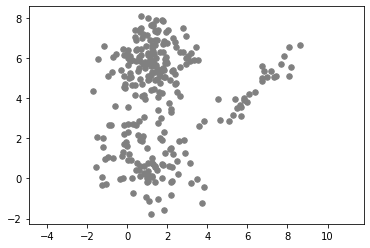

In [2]:
# Extracting data and plotting the samples
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

Note in the data we have initial values of mus, sigmas and pis. In this example, by looking at the data three clusters are assumed so that K =3

## Probability distributions in dataset
We have four distributions 
- P(z) categorical  (get_prior)
- P(X|z) Gaussians (get_likelihood)
- P(X) (get_evidence) 
- P(z|x) (get_posterior)

In [3]:
def get_prior(pi_array):
  '''The function takes an array of k probabilities, and returns a categorical distribution'''

  return tfd.OneHotCategorical(probs = pi_array)


In [4]:
def get_likelihood(mu_array, sigma_array):

  
  sigmas_LT = tf.linalg.cholesky(sigma_array)

  return tfd.MultivariateNormalTriL(loc = mu_array, scale_tril= sigmas_LT)

In [5]:
def get_posteriors(likelihood_distribution, prior_dist, processing_data):

  
  intermediate = tf.cast(likelihood_distribution.prob(processing_data), dtype = tf.float32)*prior_dist.probs
  posteriors = tf.divide(intermediate, tf.expand_dims(tf.reduce_sum(intermediate, axis = 1), axis = 1))

  return posteriors



In [6]:
def mu_update(processing_data, posteriors):
  return tf.reduce_sum(processing_data * tf.expand_dims(posteriors, axis = 2), axis = 0) / tf.expand_dims(tf.reduce_sum(posteriors, axis = 0), axis = 1)

In [7]:
def sigma_update(processing_data, updated_mu, posteriors):

  updated_sigma = []
  Nks = tf.reduce_sum(posteriors, axis = 0)
  subtraction = processing_data - tf.expand_dims(updated_mu, axis = 0) 

  for i in range(subtraction.shape[1]):
    covariance_unnorm = tf.reduce_sum(tf.expand_dims(subtraction[:,i,:], axis = 2) * tf.transpose(tf.expand_dims(subtraction[:,i,:], axis = 2), perm = [0,2,1])*posteriors[:,i][...,np.newaxis, np.newaxis], axis = 0)
    covariance_norm = covariance_unnorm / Nks[i]

    updated_sigma.append(covariance_norm.numpy())

  return updated_sigma

In [8]:
def pi_update(posteriors, N):

  return tf.reduce_sum(posteriors, axis = 0)/N

In [14]:
def get_clusters(posterior):

  return tf.argmax(posterior, axis = 1).numpy()


In [41]:
label_colors = ['purple', 'orange', 'green']
def plot_data(X, labels, label_colors):

  for c in np.unique(labels):

    inx = np.where(labels == c)
    plt.scatter(X[inx, 0], X[inx,1], c = label_colors[c], alpha = 0.6)


def make_grid(data, num_points = 100):
  x0_min, x0_max = X[:, 0].min(), X[:, 0].max()
  x1_min, x1_max = X[:, 1].min(), X[:, 1].max()
  x0 = np.linspace(x0_min, x0_max, num_points)
  x1 = np.linspace(x1_min, x1_max, num_points)
  return np.meshgrid(x0, x1)

def visualize(data,labels, likelihood_distribution, batch_shape,label_colors, num_points  = 100):
  
  plot_data(data, labels, label_colors)
  X0, X1 = make_grid(data, num_points = num_points)
  Z = likelihood_distribution.prob(np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, 1))
  Z = np.array(Z).T.reshape(batch_shape, *X0.shape)
  
  
  for batch in np.arange(batch_shape):
    plt.contour(X0, X1, Z[batch], colors=label_colors[batch], alpha=0.3)



In [11]:
processing_data = X[:,np.newaxis, :]

Text(0.5, 1.0, 'Initial state')

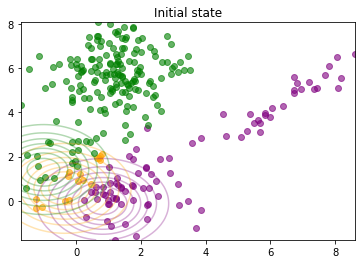

In [54]:
C = 3
d = 2
pi = 1/float(C)*np.ones(C)
mu = np.array([[ 0.82195208 ,-0.12067994],[-0.33838209 , 0.56209902],[-1.0061065  , 1.41387098]])
sigma = np.zeros((C,d,d))
sigma[...] = np.identity(d)
likelihood_distribution = get_likelihood(mu, sigma)
prior_distribution = get_prior(pi)
posterior_distribution = get_posteriors(likelihood_distribution, prior_distribution, processing_data)
labels = get_clusters(posterior_distribution)
visualize(X, labels, likelihood_distribution, 3, label_colors)
plt.title('Initial state')

In [30]:
mus_array = []
sigma_arrays = []
pi_arrays = []
N = X.shape[0]

num_of_iterations = 20
for iteration in range(num_of_iterations):

  posterior_distribution = get_posteriors(likelihood_distribution, prior_distribution, processing_data)
  
  updated_mu = mu_update(processing_data, posterior_distribution)
  updated_sigma = sigma_update(processing_data, updated_mu, posterior_distribution)
  updated_pi = pi_update(posterior_distribution, N)


  mus_array.append(updated_mu)
  sigma_arrays.append(updated_sigma)
  pi_arrays.append(updated_pi)
  likelihood_distribution = get_likelihood(updated_mu, updated_sigma)
  prior_distribution = get_prior(updated_pi)


Text(0.5, 1.0, 'Iteration 20')

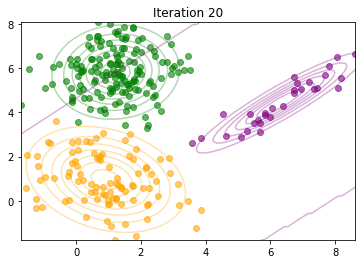

In [55]:
likelihood_distribution = get_likelihood(mus_array[19], sigma_arrays[19])
prior_distribution = get_prior(pi_arrays[19])
posterior_distribution = get_posteriors(likelihood_distribution, prior_distribution, processing_data)
labels = get_clusters(posterior_distribution)
visualize(X, labels, likelihood_distribution, 3, label_colors)
plt.title('Iteration 20')